In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score

                                               CPU_temp_corr  GPU_temp_corr
CPU temperature - Centigrade Degrees (°C)           1.000000       0.193865
CPU consumption - Percentage (%)                    0.913875       0.268283
RAM memory power consumption - Percentage (%)       0.897479      -0.122440
Power factor - Adimentional                         0.566998       0.088854
CPU power consumption - Percentage (%)              0.507332       0.334275
Voltage (V)                                         0.214539       0.492108
GPU temperature - Centigrade Degrees (°C)           0.193865       1.000000
Power (PA) - Watts (W)                              0.180641       0.287498
pres                                                0.176910       0.118711
GPU consumption - Percentage (%)                    0.128074       0.279518
rhum                                                0.124397       0.048285
GPU power consumption - Percentage (%)              0.117057       0.427492
dwpt        

<Axes: >

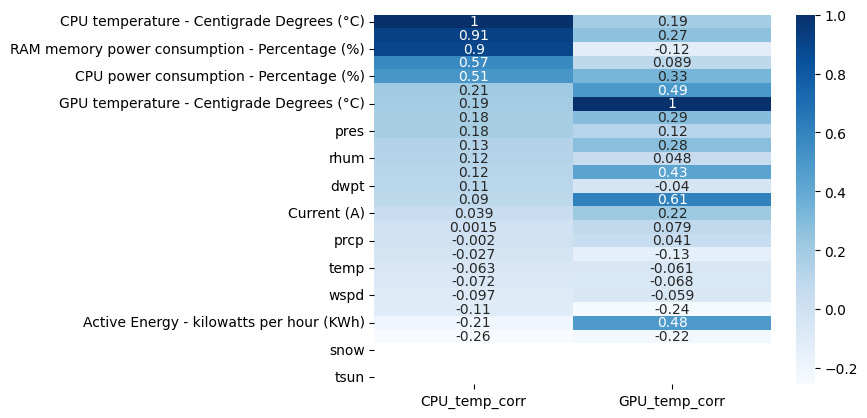

In [2]:
df = pd.read_csv('/kaggle/input/dataset-temp2/integrated_with_climate_factor.csv')

# Clean column names (remove leading/trailing whitespace)
df.columns = df.columns.str.strip()

# Compute correlation matrix (only for numeric columns)
correlation_matrix = df.corr(numeric_only=True)

# Focus on CPU and GPU temperature correlation with all columns
cpu_temp_corr = correlation_matrix.loc['CPU temperature - Centigrade Degrees (°C)']
gpu_temp_corr = correlation_matrix.loc['GPU temperature - Centigrade Degrees (°C)']

# Combine into a single DataFrame for comparison
combined_corr = pd.DataFrame({
    'CPU_temp_corr': cpu_temp_corr,
    'GPU_temp_corr': gpu_temp_corr
}).sort_values(by='CPU_temp_corr', ascending=False)

# correlations
print(combined_corr)

sns.heatmap(combined_corr, cmap="Blues", annot=True)

In [3]:
# Clean up column names
df.columns = df.columns.str.strip()

# selected features based on correlation analysis
selected_columns = [
    'CPU consumption - Percentage (%)',
    'RAM memory power consumption - Percentage (%)',
    'Power factor - Adimentional',
    'CPU power consumption - Percentage (%)',
    'Voltage (V)',
    'GPU temperature - Centigrade Degrees (°C)',
    'Power (PA) - Watts (W)',
    'pres', 
    'GPU consumption - Percentage (%)',
    'rhum', 
    'GPU power consumption - Percentage (%)',
    'dwpt', 
    'RAM memory consumption - Percentage (%)',
    'Current (A)',
    'Active Energy - kilowatts per hour (KWh)',
    'CPU temperature - Centigrade Degrees (°C)'  # Target variable
]

# Ensure the columns actually exist in the DataFrame (safe filtering)
selected_columns = [col for col in selected_columns if col in df.columns]

# Create a new DataFrame with just the selected features
selected_features_df = df[selected_columns]

print(selected_features_df.head())


   CPU consumption - Percentage (%)  \
0                          11.61642   
1                          10.72589   
2                          10.33789   
3                           8.21179   
4                           8.35544   

   RAM memory power consumption - Percentage (%)  Power factor - Adimentional  \
0                                       11.52830                      0.91264   
1                                       11.88607                      0.91107   
2                                       11.18930                      0.91053   
3                                       10.77268                      0.90911   
4                                       10.08281                      0.90982   

   CPU power consumption - Percentage (%)  Voltage (V)  \
0                                36.90283    119.90943   
1                                37.44643    119.93571   
2                                37.83842    119.93333   
3                                38.02821    1

In [4]:
df = df[selected_columns]

# 1. Handle missing values # Drop rows where target variable is missing
df = df.dropna(subset=['CPU temperature - Centigrade Degrees (°C)'])

# Fill remaining missing values with column median (robust to outliers)
df.fillna(df.median(numeric_only=True), inplace=True)

# 2. Handle outliers using IQR
def remove_outliers_iqr(data, factor=1.5):
    df_no_outliers = data.copy()
    for col in df_no_outliers.columns:
        Q1 = df_no_outliers[col].quantile(0.25)
        Q3 = df_no_outliers[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - factor * IQR
        upper_bound = Q3 + factor * IQR
        df_no_outliers = df_no_outliers[(df_no_outliers[col] >= lower_bound) & (df_no_outliers[col] <= upper_bound)]
    return df_no_outliers

df_clean = remove_outliers_iqr(df)

# 3. Separate features and target
X = df_clean.drop('CPU temperature - Centigrade Degrees (°C)', axis=1)
y = df_clean['CPU temperature - Centigrade Degrees (°C)']

# 4. Scale features 
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# convert back to DataFrame
X_scaled_df = pd.DataFrame(X_scaled, columns=X.columns)

# Final data ready
print("Preprocessing complete!")
print(f"X shape: {X_scaled_df.shape}, y shape: {y.shape}")

Preprocessing complete!
X shape: (32604, 15), y shape: (32604,)


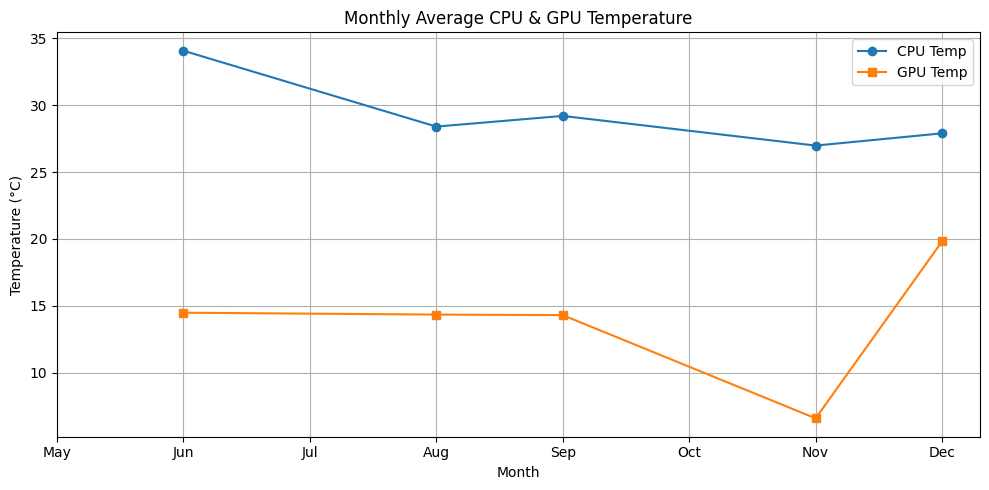

In [5]:
#  all columns
df = pd.read_csv("/kaggle/input/dataset-temp2/integrated_with_climate_factor.csv")
df.columns = df.columns.str.strip()

# Ensure 'timestamp' exists and parse it
if 'timestamp' in df.columns:
    df['timestamp'] = pd.to_datetime(df['timestamp'], errors='coerce')
    df['month'] = df['timestamp'].dt.month

    # Drop rows with invalid timestamps or missing target variables
    df = df.dropna(subset=['month', 
                           'CPU temperature - Centigrade Degrees (°C)', 
                           'GPU temperature - Centigrade Degrees (°C)'])

    # Group by month and compute mean temperatures
    monthly_means = df.groupby('month')[
        ['CPU temperature - Centigrade Degrees (°C)', 
         'GPU temperature - Centigrade Degrees (°C)']
    ].mean()

    plt.figure(figsize=(10, 5))
    plt.plot(monthly_means.index, monthly_means['CPU temperature - Centigrade Degrees (°C)'],
             marker='o', label='CPU Temp')
    plt.plot(monthly_means.index, monthly_means['GPU temperature - Centigrade Degrees (°C)'],
             marker='s', label='GPU Temp')
    plt.title("Monthly Average CPU & GPU Temperature")
    plt.xlabel("Month")
    plt.ylabel("Temperature (°C)")
    plt.xticks(range(5, 13), ['May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

In [6]:
# Separate weather and system-related features
weather_cols = ['temp', 'dwpt', 'rhum', 'prcp']
system_cols = [col for col in selected_columns if col not in weather_cols]
target_cols = ['CPU temperature - Centigrade Degrees (°C)', 'GPU temperature - Centigrade Degrees (°C)']

# Filter columns that actually exist
weather_cols = [col for col in weather_cols if col in df.columns]
system_cols = [col for col in system_cols if col in df.columns]

cpu_cols = [col for col in system_cols if col != 'CPU temperature - Centigrade Degrees (°C)']
gpu_cols = [col for col in system_cols if col != 'GPU temperature - Centigrade Degrees (°C)']

# Keep timestamp for time series modeling
df['timestamp'] = pd.to_datetime(df['timestamp'], errors='coerce')
df = df.dropna(subset=['timestamp'])

# Set timestamp as index
df.set_index('timestamp', inplace=True)

# Final weather and system datasets
df_weather = df[weather_cols]

In [7]:
from sklearn.model_selection import train_test_split

cpu_target = 'CPU temperature - Centigrade Degrees (°C)'
gpu_target = 'GPU temperature - Centigrade Degrees (°C)'

X_cpu_cols = cpu_cols + weather_cols
X_gpu_cols = gpu_cols + weather_cols

X_cpu = df[X_cpu_cols].copy()
X_gpu = df[X_gpu_cols].copy()

X_cpu['month'] = df.index.month
X_cpu['season'] = X_cpu['month'] % 12 // 3 + 1

X_gpu['month'] = df.index.month
X_gpu['season'] = X_gpu['month'] % 12 // 3 + 1

# Targets
y_cpu = df[cpu_target]
y_gpu = df[gpu_target]

# Train-test splits
X_train_cpu, X_test_cpu, y_cpu_train, y_cpu_test = train_test_split(X_cpu, y_cpu, test_size=0.2, random_state=42)
X_train_gpu, X_test_gpu, y_gpu_train, y_gpu_test = train_test_split(X_gpu, y_gpu, test_size=0.2, random_state=42)


In [8]:
from sklearn.metrics import mean_squared_error, r2_score
import lightgbm as lgb
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

2026-02-07 06:13:34.912213: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1770444815.072165      55 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1770444815.120339      55 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1770444815.495391      55 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1770444815.495420      55 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1770444815.495423      55 computation_placer.cc:177] computation placer alr

In [9]:
target_series_train = y_gpu_train.sort_index()
target_series_test  = y_gpu_test.sort_index()

X_train = X_train_gpu.sort_index()
X_test  = X_test_gpu.sort_index()

In [10]:
# LightBGM

print("\nTraining LightGBM...")

lgb_model = lgb.LGBMRegressor(
    n_estimators=600,
    learning_rate=0.01,
    max_depth=8,
    num_leaves=64,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    n_jobs=-1,
    verbose=-1
)

lgb_model.fit(X_train, target_series_train)

lgb_pred = lgb_model.predict(X_test)

lgb_rmse = np.sqrt(mean_squared_error(target_series_test, lgb_pred))
lgb_r2   = r2_score(target_series_test, lgb_pred)

print("\n=== LightGBM Results ===")
print("RMSE:", lgb_rmse)
print("R²:", lgb_r2)


Training LightGBM...

=== LightGBM Results ===
RMSE: 0.19382283709045225
R²: 0.9986628523840103


In [11]:
# LSTM

print("\nTraining LSTM...")

SEQ_LENGTH = 30

def create_sequences(X, y, seq_len):
    Xs, ys = [], []
    for i in range(len(X) - seq_len):
        Xs.append(X[i:i+seq_len])
        ys.append(y[i+seq_len])
    return np.array(Xs), np.array(ys)


X_train_seq, y_train_seq = create_sequences(X_train.values, target_series_train.values, SEQ_LENGTH)
X_test_seq,  y_test_seq  = create_sequences(X_test.values,  target_series_test.values,  SEQ_LENGTH)


lstm_model = Sequential([
    LSTM(256, return_sequences=True, input_shape=(SEQ_LENGTH, X_train.shape[1])),
    Dropout(0.1),
    LSTM(256),
    Dropout(0.1),
    Dense(64, activation='relu'),
    Dense(1)
])

lstm_model.compile(optimizer='adam', loss='mse')

early_stop = EarlyStopping(patience=5, restore_best_weights=True)

lstm_model.fit(
    X_train_seq, y_train_seq,
    epochs=3,
    batch_size=32,
    validation_split=0.1,
    callbacks=[early_stop],
    verbose=0
)

lstm_pred = lstm_model.predict(X_test_seq).flatten()

lstm_rmse = np.sqrt(mean_squared_error(y_test_seq, lstm_pred))
lstm_r2   = r2_score(y_test_seq, lstm_pred)

print("\n=== LSTM Results ===")
print("RMSE:", lstm_rmse)
print("R²:", lstm_r2)



Training LSTM...


I0000 00:00:1770444829.886563      55 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13757 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1770444829.892327      55 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13757 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5
/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
I0000 00:00:1770444834.077145     128 cuda_dnn.cc:529] Loaded cuDNN version 91002


521/521 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step

=== LSTM Results ===
RMSE: 4.486132868210095
R²: 0.2849507593659848


In [12]:
# ENSEMBLE (LightGBM + LSTM)

print("\nSearching best ensemble weights...")

weights_to_test = [
    (0.6, 0.4),
    (0.5, 0.5),
    (0.7, 0.3),
    (0.4, 0.6)
]

best_rmse = 999
best_weights = None

lgb_arr = lgb_pred[SEQ_LENGTH:]
y_true  = y_test_seq

for w in weights_to_test:
    ensemble_pred = w[0]*lgb_arr + w[1]*lstm_pred
    rmse = np.sqrt(mean_squared_error(y_true, ensemble_pred))

    if rmse < best_rmse:
        best_rmse = rmse
        best_weights = w

print("Best weights:", best_weights)


ensemble_pred = best_weights[0]*lgb_arr + best_weights[1]*lstm_pred

ensemble_rmse = np.sqrt(mean_squared_error(y_true, ensemble_pred))
ensemble_r2   = r2_score(y_true, ensemble_pred)

print("\n=== FINAL ENSEMBLE RESULTS ===")
print("RMSE:", ensemble_rmse)
print("R²:", ensemble_r2)



Searching best ensemble weights...
Best weights: (0.7, 0.3)

=== FINAL ENSEMBLE RESULTS ===
RMSE: 1.3664837428254222
R²: 0.9336561571166047


In [13]:
from sklearn.metrics import mean_squared_error, r2_score
import lightgbm as lgb
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.dates as mdates

In [14]:
def create_sequences(X, y, seq_len):
    Xs, ys = [], []
    for i in range(len(X) - seq_len):
        Xs.append(X[i:i+seq_len])
        ys.append(y[i+seq_len])
    return np.array(Xs), np.array(ys)


================ CPU MODEL ================

Training LightGBM...
LightGBM RMSE: 0.1937576905639355
Training LSTM...


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


521/521 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
LSTM RMSE: 2.525577977926804

FINAL CPU Ensemble RMSE: 0.8042655090494255
FINAL CPU Ensemble R²: 0.9568005267641999
Best weights: (0.7, 0.3)


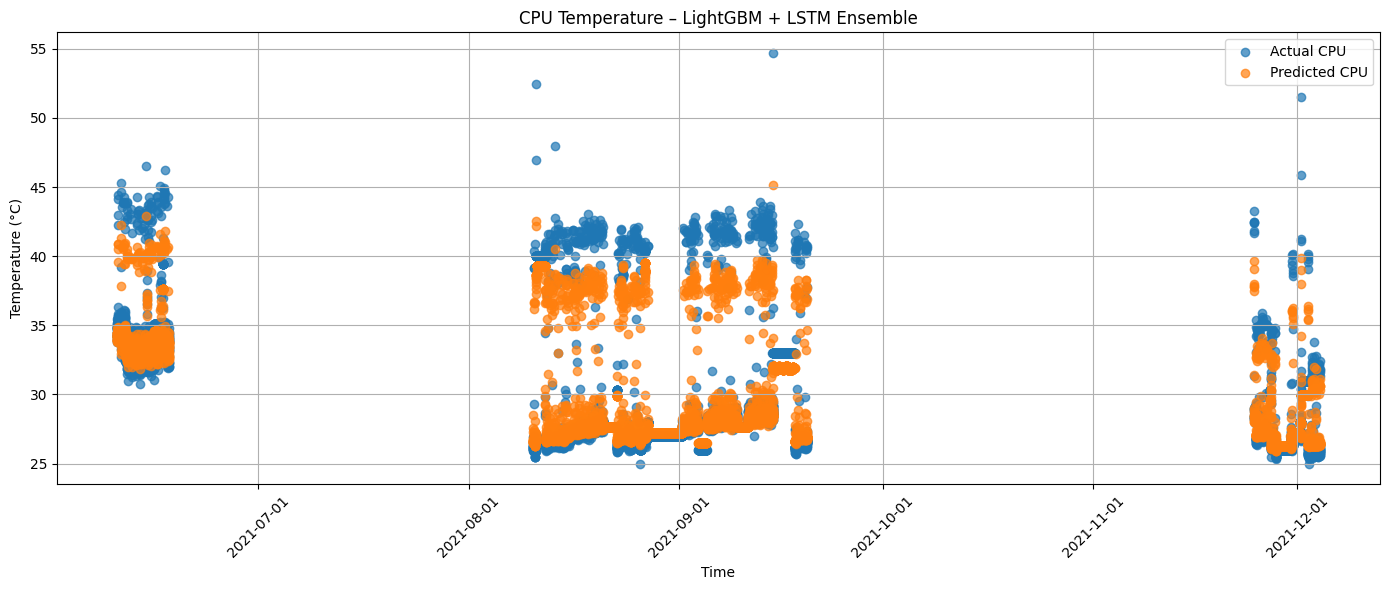


================ GPU MODEL ================

Training LightGBM...
LightGBM RMSE: 0.19854277745896998
Training LSTM...


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


521/521 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
LSTM RMSE: 4.5474264470719055

FINAL GPU Ensemble RMSE: 1.3981462665939866
FINAL GPU Ensemble R²: 0.9305460579840596
Best weights: (0.7, 0.3)


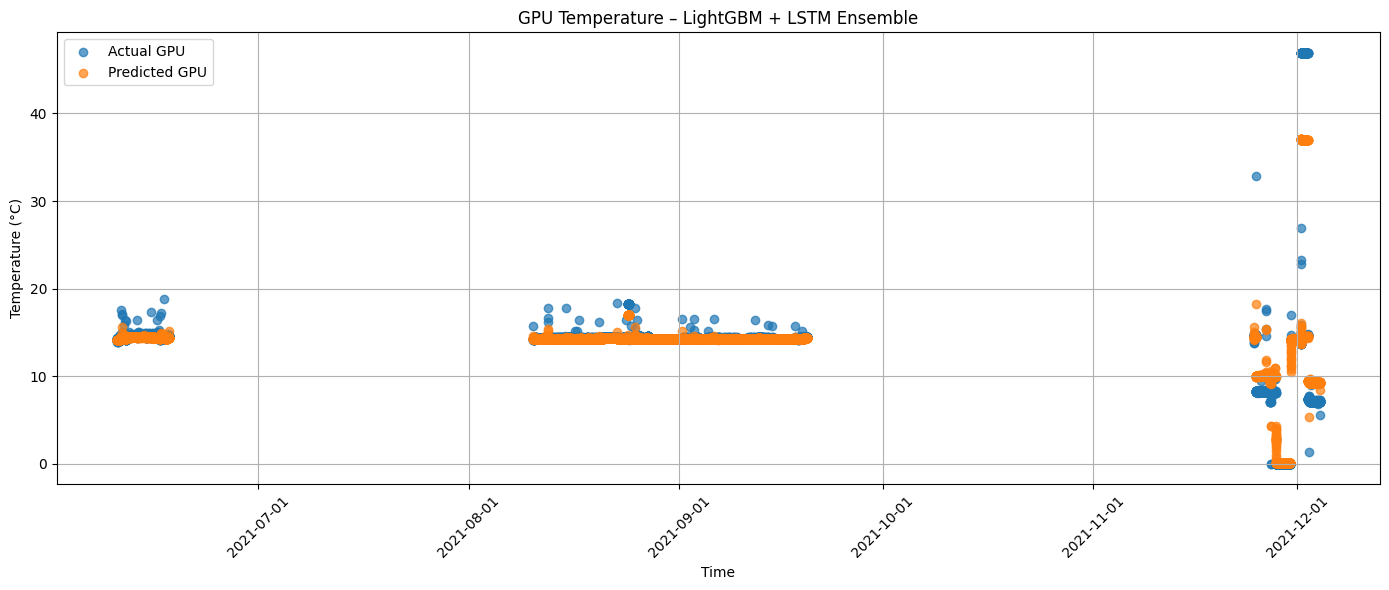

In [15]:
def train_lgbm_lstm_ensemble(X_train, X_test, y_train, y_test, label):

    print(f"\n================ {label} MODEL ================\n")

    X_train = X_train.sort_index()
    X_test  = X_test.sort_index()
    y_train = y_train.sort_index()
    y_test  = y_test.sort_index()

    # LIGHTGBM
    print("Training LightGBM...")

    lgb_model = lgb.LGBMRegressor(
        n_estimators=500,
        learning_rate=0.01,
        max_depth=8,
        num_leaves=64,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42,
        n_jobs=-1
    )

    lgb_model.fit(X_train, y_train)
    lgb_pred = lgb_model.predict(X_test)

    print("LightGBM RMSE:",
          np.sqrt(mean_squared_error(y_test, lgb_pred)))


    # LSTM
    print("Training LSTM...")

    SEQ_LENGTH = 30

    X_train_seq, y_train_seq = create_sequences(X_train.values, y_train.values, SEQ_LENGTH)
    X_test_seq,  y_test_seq  = create_sequences(X_test.values,  y_test.values,  SEQ_LENGTH)

    lstm_model = Sequential([
        LSTM(128, return_sequences=True, input_shape=(SEQ_LENGTH, X_train.shape[1])),
        Dropout(0.1),
        LSTM(64),
        Dense(32, activation='relu'),
        Dense(1)
    ])

    lstm_model.compile(optimizer='adam', loss='mse')

    early_stop = EarlyStopping(patience=5, restore_best_weights=True)

    lstm_model.fit(
        X_train_seq, y_train_seq,
        epochs=20,
        batch_size=32,
        validation_split=0.1,
        callbacks=[early_stop],
        verbose=0
    )

    lstm_pred = lstm_model.predict(X_test_seq).flatten()

    print("LSTM RMSE:",
          np.sqrt(mean_squared_error(y_test_seq, lstm_pred)))


    # ENSEMBLE

    lgb_arr = lgb_pred[SEQ_LENGTH:]
    y_true  = y_test_seq

    weights_to_test = [(0.6,0.4),(0.5,0.5),(0.7,0.3),(0.4,0.6)]

    best_rmse = 999
    best_weights = None

    for w in weights_to_test:
        pred = w[0]*lgb_arr + w[1]*lstm_pred
        rmse = np.sqrt(mean_squared_error(y_true, pred))

        if rmse < best_rmse:
            best_rmse = rmse
            best_weights = w

    ensemble_pred = best_weights[0]*lgb_arr + best_weights[1]*lstm_pred

    r2 = r2_score(y_true, ensemble_pred)

    print(f"\nFINAL {label} Ensemble RMSE:", best_rmse)
    print(f"FINAL {label} Ensemble R²:", r2)
    print("Best weights:", best_weights)

    time_index = y_test.index[SEQ_LENGTH:]  

    plt.figure(figsize=(14,6))
    
    plt.scatter(time_index, y_true, alpha=0.7, label=f'Actual {label}')
    plt.scatter(time_index, ensemble_pred, alpha=0.7, label=f'Predicted {label}')
    
    plt.title(f"{label} Temperature – LightGBM + LSTM Ensemble")
    plt.xlabel("Time")
    plt.ylabel("Temperature (°C)")
    plt.legend()
    plt.grid(True)
    
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    plt.gca().xaxis.set_major_locator(mdates.AutoDateLocator())
    
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()


# run for both
train_lgbm_lstm_ensemble(
    X_train_cpu, X_test_cpu,
    y_cpu_train, y_cpu_test,
    label="CPU"
)

train_lgbm_lstm_ensemble(
    X_train_gpu, X_test_gpu,
    y_gpu_train, y_gpu_test,
    label="GPU"
)